# Mixture density network

In [58]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from functools import partial
from chex import dataclass
from flax.training.train_state import TrainState

In [29]:
%config InlineBackend.figure_format="retina"

In [34]:
key = jax.random.PRNGKey(314)
key_data, key_train = jax.random.split(key)
key_x, key_y = jax.random.split(key_data)

In [35]:
n_samples = 200

x = jax.random.uniform(key_x, minval=0, maxval=1, shape=(n_samples,))
noise  = jax.random.uniform(key_y, minval=-0.1, maxval=0.1, shape=(n_samples,))
y = x + 0.3 * jnp.sin(2 * jnp.pi * x) + noise

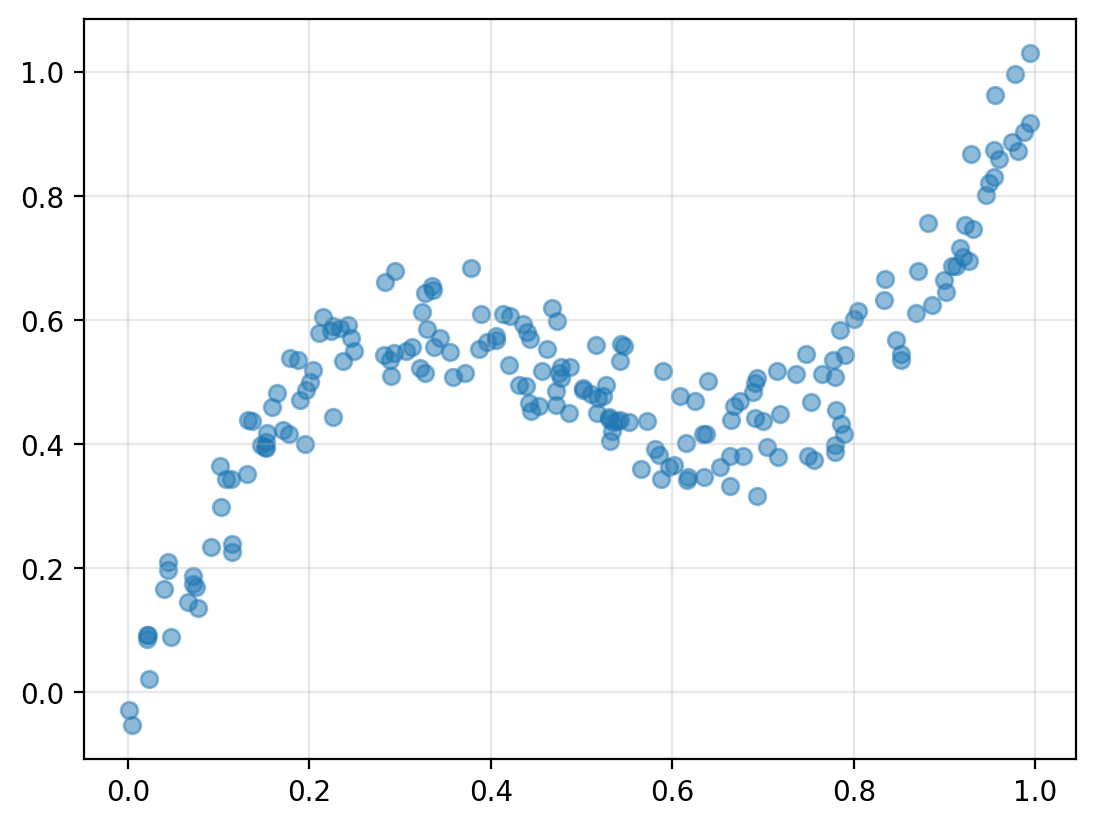

In [36]:
plt.scatter(x, y, alpha=0.5)
plt.grid(alpha=0.3)

## The forward and inverse problems

In [37]:
class SimpleMLP(nn.Module):
    n_hidden: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(6)(x)
        x = nn.tanh(x)
        x = nn.Dense(6)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x

In [64]:
def lossfn(params, x, y, apply_fn):
    yhat = apply_fn(params, x[:, None]).ravel()
    return jnp.power(y - yhat, 2).mean()
    

def train_step(state, i, x, y):
    loss, grads = jax.value_and_grad(lossfn)(state.params, x, y, state.apply_fn)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [65]:
model = SimpleMLP(n_hidden=6)
params_init = model.init(key_train, x[:, None])
state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-2)
)

In [66]:
part_step = partial(train_step, x=x, y=y)
n_steps = 10_000
steps = jnp.arange(n_steps)
state_final, losses = jax.lax.scan(part_step, state, steps)

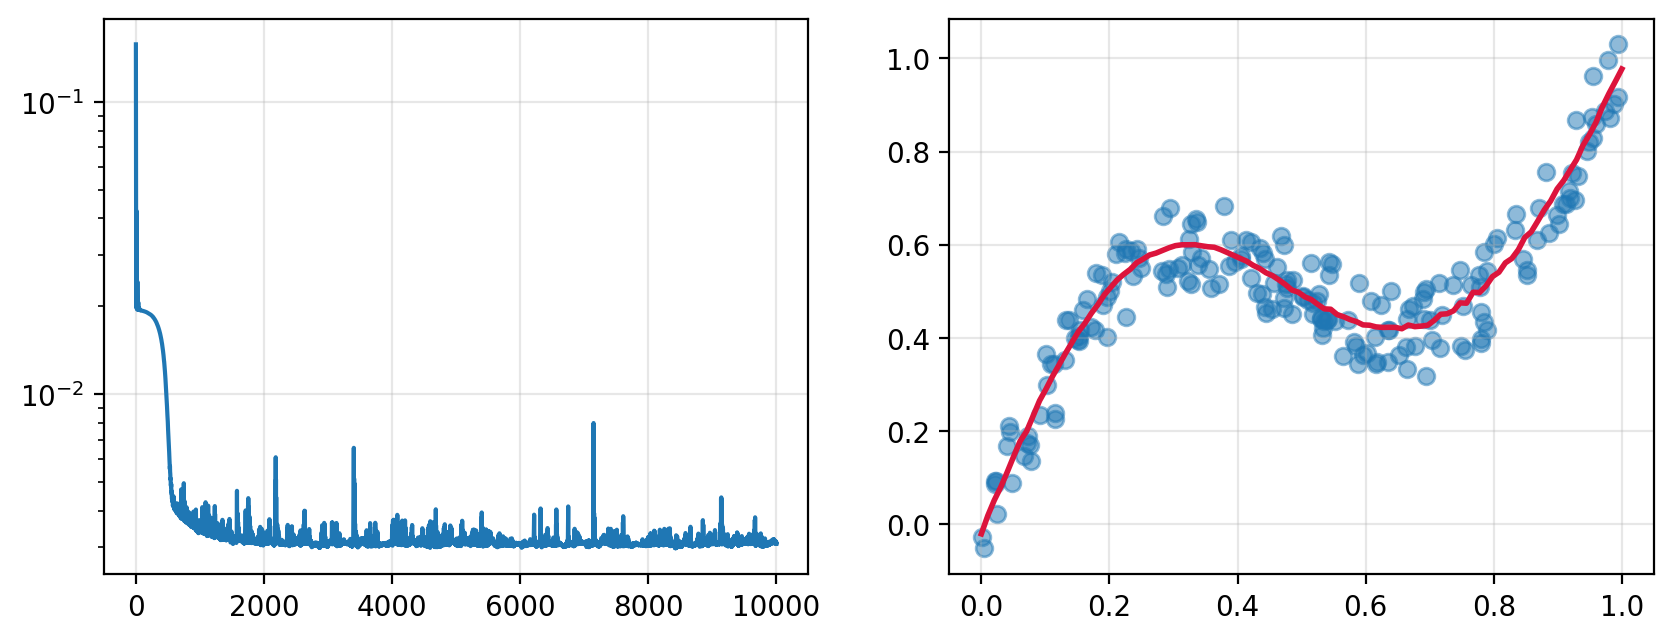

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.6))

ax[0].plot(losses)
ax[0].set_yscale("log")
ax[0].grid(alpha=0.3)

xrange = jnp.linspace(0, 1, 100)
yhat = model.apply(state_final.params, xrange[:, None])
ax[1].plot(xrange, yhat, c="crimson", linewidth=2)
ax[1].scatter(x, y, alpha=0.5)
ax[1].grid(alpha=0.3)

In [91]:
part_step = partial(train_step, x=y, y=x)
n_steps = 10_000
steps = jnp.arange(n_steps)
state_final, losses = jax.lax.scan(part_step, state, steps)

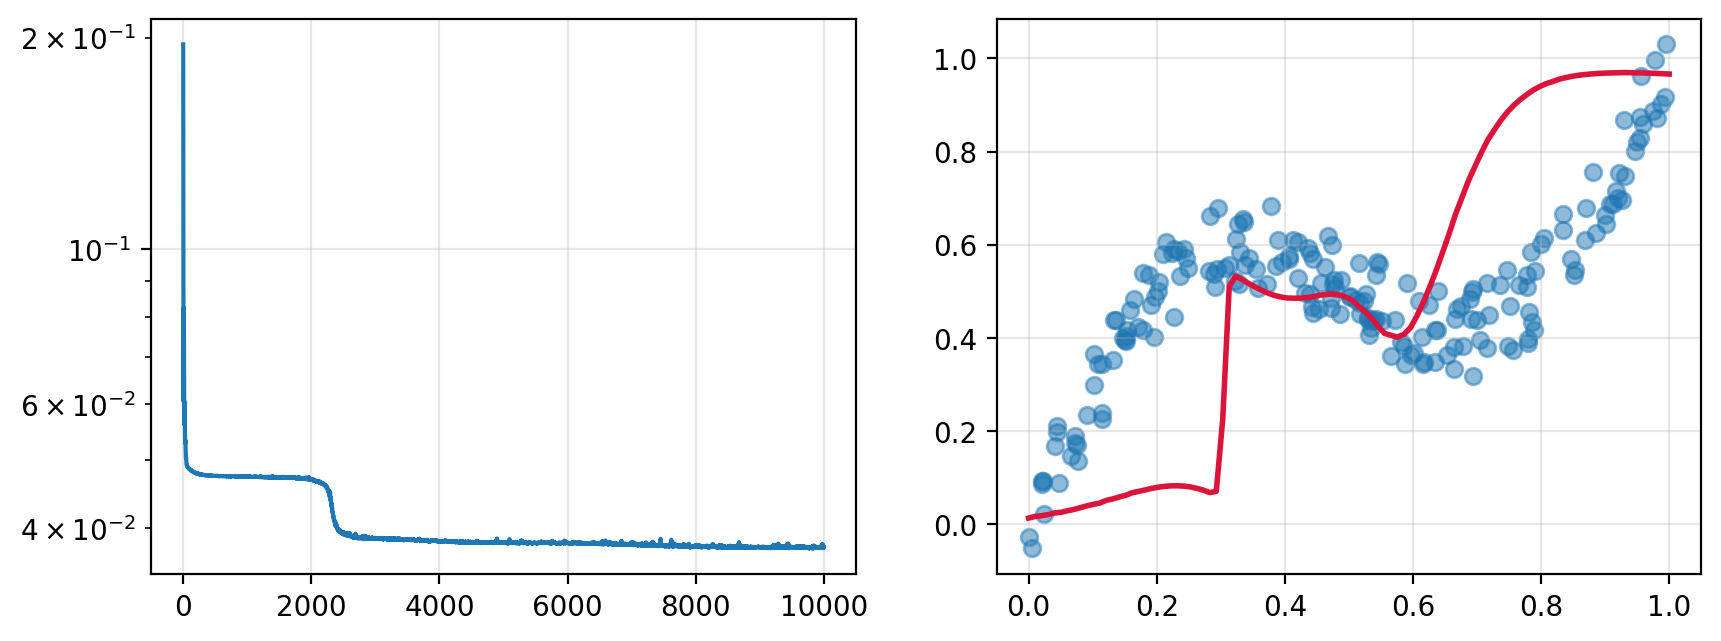

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.6))

ax[0].plot(losses)
ax[0].set_yscale("log")
ax[0].grid(alpha=0.3)

xrange = jnp.linspace(0, 1, 100)
yhat = model.apply(state_final.params, xrange[:, None])
ax[1].plot(xrange, yhat, c="crimson", linewidth=2)
ax[1].scatter(x, y, alpha=0.5)
ax[1].grid(alpha=0.3)